<a href="https://colab.research.google.com/github/thomasawolff/Machine-Learning-Projects/blob/master/UC_Mercer_CNN_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import csv
import glob
import time 
import pathlib
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import compat
from google.colab import drive
#from tensorflow import GPUOptions
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import Xception
#from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import TensorBoard
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

##gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
##sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

drive.mount('/content/drive')
print(os.chdir('/content/drive/MyDrive/UCMerced_LandUse'))

home = r'/content/drive/MyDrive/UCMerced_LandUse'
name = 'LandUsePredict-cnn-64x2-{}'.format(time.time())
tensorboard = TensorBoard(log_dir=home+'\\logs\\{}'.format(name),
                          histogram_freq=1,
                          write_images=True)


############## This model uses tensorflow-GPU 2.0.0 #################

#path = (r'https://drive.google.com/drive/folders/1LS7mECdPTtcCmSUcOVKMOnsCndwHx-Dh')
path = (r'/content/drive/MyDrive/UCMerced_LandUse')
train_dir = os.path.join(path, 'trainImages')
test_dir = os.path.join(path, 'testImages')
train_dir = pathlib.Path(train_dir)
test_dir = pathlib.Path(test_dir)
test_image_count = len(list(test_dir.glob('*/*.tif')))

Found 1539 images belonging to 21 classes.
Found 567 images belonging to 21 classes.
                                                                                       Layer Type  ... Layer Trainable
0                <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fc99c32cb00>  ...            True
1                  <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc99c32cb38>  ...            True
2   <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fc99c4b12e8>  ...            True
3             <tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7fc99c381780>  ...            True
4         <tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x7fc99c530fd0>  ...            True
..                                                                                            ...  ...             ...
87                           <tensorflow.python.keras.layers.core.Dense object at 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
76/76 [==============================] - 1036s 14s/step - loss: 3.1628 - accuracy: 0.0985 - val_loss: 2.3195 - val_accuracy: 0.4198
Epoch 2/30
76/76 [==============================] - 26s 348ms/step - loss: 2.2506 - accuracy: 0.3643 - val_loss: 1.5773 - val_accuracy: 0.6120
Epoch 3/30
76/76 [==============================] - 27s 349ms/step - loss: 1.5801 - accuracy: 0.5766 - val_loss: 1.1148 - val_accuracy: 0.7266
Epoch 4/30
76/76 [==============================] - 26s 345ms/step - loss: 1.1205 - accuracy: 0.7272 - val_loss: 0.8274 - val_accuracy: 0.8060
Epoch 5/30
76/76 [==============================] - 26s 342ms/step - loss: 0.9122 - accuracy: 0.7626 - val_loss: 0.6621 - val_accuracy: 0.8325
Epoch 6/30
76/76 [==============================] - 26s 345ms/step - loss: 0.7152 - accuracy: 0.8065 - val_loss: 0.5382 - val_accuracy: 0.8624
Epoch 7/30
76/76 [==============================] - 26s 343ms/step - loss: 0.5968 - accuracy: 0.8414 - val_loss: 0.4798 - val_accuracy: 0.8660

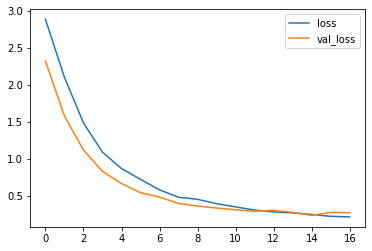

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [8]:
class dataSetupRun(object):

    def __init__(self):

        self.preTrainedModel = 'imagenet' # pretrained model used for classification
        self.denseActivationFunc = 'relu' # activation function used with in dense layers
        self.predsActivationFunc = 'softmax' # activation function used to measure loss
        self.optimizerFunc = 'adagrad' # optimizer for backpropagation
        self.classMode = 'categorical' # there are 21 class labels so this is not binary
        self.batch_size = 20 # the number of images included processed at once for classification
        self.img_height = 224
        self.img_width = 224
        self.total_train = 1533
        self.labelNumber = 21
        self.dropout = 0.5
        self.epochs = 30 # the number of iterations through training set
        self.bands = 3 # color image has 3 color bands, red, green, blue

        with tf.device('/cpu:0'):
            model = Xception(weights=None,
                     input_shape=(self.img_height, self.img_width, self.bands),
                     classes=21)

    def arrangeData(self):

        # training image generator. in this generator I am modifying the training images each iteration
        # so as to prevent overfitting during training. validation images are not modified.
        image_generator = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=6,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')


        # generating the training images and converting them into data usable by the classification algorithm
        self.train_data_gen = image_generator.flow_from_directory(batch_size=self.batch_size,
                                                        directory=train_dir,
                                                        shuffle=True, # images will be shuffled each iteration
                                                        color_mode="rgb",
                                                        target_size=(self.img_height, self.img_width),
                                                        class_mode=self.classMode)


        # generating the test images which are seperate from train and validation images
        # which the algorithm will have not seen
        self.test_data_gen = image_generator.flow_from_directory(directory=test_dir,
                                                        color_mode="rgb",
                                                        target_size=(self.img_height, self.img_width),
                                                        class_mode=self.classMode,
                                                        shuffle=False)
                                                        #save_to_dir = path+'\\testImagesPredicted',
                                                        #save_format = 'jpeg')

    def modelSetupRun(self):
        self.arrangeData()

        # 50% of dense layers nodes will be removed
        dropout1 = Dropout(self.dropout) # dropout randomly removes nodes from the CNN each iteration
        dropout2 = Dropout(self.dropout) # this prevents overfitting to training data by

        # assigning the pre-trained model MobileNet to the variable base_model
        base_model=MobileNet(input_shape=(self.img_height,self.img_width,self.bands),\
                             weights=self.preTrainedModel,include_top=False)

        denseLayers = base_model.output # brining in the output from the base_model into dense layers
        denseLayers = GlobalAveragePooling2D()(denseLayers) # performing pooling function
        denseLayers = Dense(1024,activation = self.denseActivationFunc)(denseLayers) #dense layer 1
        denseLayers = dropout2(denseLayers)
        denseLayers = Dense(512,activation = self.denseActivationFunc)(denseLayers) #dense layer 3
        denseLayers = Flatten()(denseLayers)

        preds = Dense(self.labelNumber,activation = self.predsActivationFunc)(denseLayers) #final dense layer with softmax activation

        modeler = Model(inputs=base_model.input, outputs=preds)
        self.model = modeler

        #self.model.trainable = False # setting the pretrained model to be trainable
##        for layer in base_model.layers:
##            layer.trainable = True

        pd.set_option('max_colwidth', None)
        layers = [(layer, layer.name, layer.trainable) for layer in self.model.layers]
        print(pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']))

        self.model.compile(optimizer=self.optimizerFunc, # compiling the model using adagrad optimizer
                      loss=CategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

        self.model.summary()

        early_stop = EarlyStopping(monitor='val_loss',patience=2)

         # training the model and doing initial evalution using validation data
        self.history = self.model.fit_generator(
            self.train_data_gen,
            steps_per_epoch=self.total_train // self.batch_size,
            epochs=self.epochs,
            validation_data=self.test_data_gen,
            callbacks = [tensorboard,early_stop]
        )

        losses = pd.DataFrame(self.model.history.history)
        losses[['loss','val_loss']].plot()
        plt.show()
        
        #self.model.save('savedClassModel.h5')

    def testDataPredictionsWrite(self):
        self.modelSetupRun()
        loss = self.model.evaluate_generator(generator=self.test_data_gen)
        predict = self.model.predict_generator(generator=self.test_data_gen)
        predicted_class_indices=np.argmax(predict,axis=1)

        labels = (self.test_data_gen.class_indices)
        labels = dict((v,k) for k,v in labels.items())
        self.predictions = [labels[k] for k in predicted_class_indices]

        self.filenames=self.test_data_gen.filenames
        results=pd.DataFrame({'Filename':self.filenames,'Predictions':self.predictions})

        try:
            results.to_csv('CNN_Results_Output.csv', sep='\t')
        except Exception as r:
            print(r)
            input('Press Enter to leave')


    def performanceViz(self):
        self.modelSetupRun()

        history_dict = self.history.history
        acc = history_dict['acc']
        val_acc = history_dict['val_acc']
        loss = history_dict['loss']
        val_loss = history_dict['val_loss']

        compat.v1.RunOptions(report_tensor_allocations_upon_oom = True)

        print(acc)
        epochs_range = range(self.epochs)

        plt.figure(figsize=(8, 8))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.show()

go = dataSetupRun()
#go.modelSetupRun()
#go.show_batch()
#go.performanceViz()
#go.arrangeData()
#go.validationDataPredictions()
go.testDataPredictionsWrite()